# DLIME

In this work, we propose a deterministic version of Local Interpretable Model Agnostic Explanations (LIME) and the experimental results on three different medical datasets shows the superiority for Deterministic Local Interpretable Model-Agnostic Explanations (DLIME).

## Load Required Packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from load_dataset import LoadDataset

%matplotlib inline

## Load dataset

In [5]:
# We are using breast cancer dataset :  https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
comp_data = LoadDataset(which='bc')
X = comp_data.data.data

feature_names = comp_data.data.feature_names
target_names = comp_data.data.target_names

## Split dataset

In [6]:
#train, test, labels_train, labels_test = train_test_split(test.data.data, test.data.target, train_size=0.80)
# np.save("X_train.npy", train)
# np.save("X_test.npy", test)
# np.save("y_train.npy", labels_train)
# np.save("y_test.npy", labels_test)

train = np.load("data/X_train.npy")
test = np.load("data/X_test.npy")
labels_train = np.load("data/y_train.npy")
labels_test = np.load("data/y_test.npy")

## Train Random Forest model

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=0, max_depth=5, max_features=5)
rf.fit(train, labels_train)
mean_accuracy = rf.score(test, labels_test)
mean_accuracy

0.956140350877193

## Load Explainer

In [8]:
from explainer_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(train,   mode="classification", feature_names=feature_names,
                                 class_names=target_names, discretize_continuous=True,  verbose=False)

## Apply Hierarchical Clustering on training data 

In [9]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(X)
names = list(feature_names)+["membership"]
clustered_data = np.column_stack([X, clustering.labels_])

## Train KNN to find the local subspace

In [10]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train)
distances, indices = nbrs.kneighbors(test)
clabel = clustering.labels_

## Implement Jaccard Similarity and Jaccard Distance

In [11]:
# Computes the similarity of  items 
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

#Computes thedissimilarity of items 
def jaccard_distance(usecase):
    sim = []
    for l in usecase:
        i_sim = []
        for j in usecase:
            i_sim.append(1 - jaccard_similarity(l, j))
        sim.append(i_sim)
    return sim

## Explain an Instance With LIME and DLIME

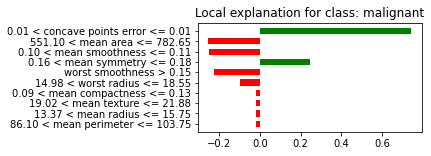

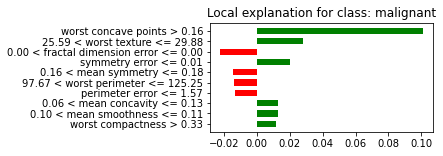

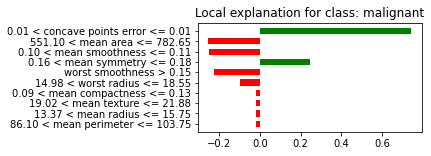

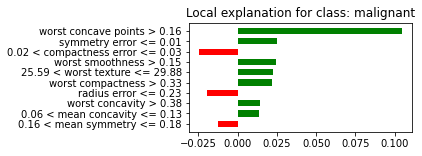

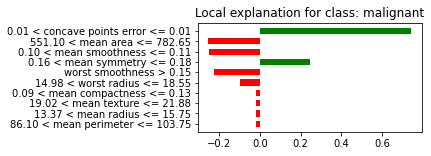

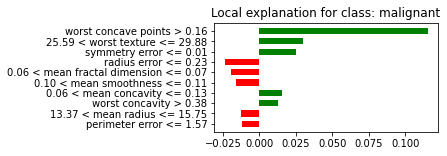

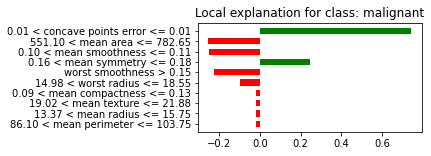

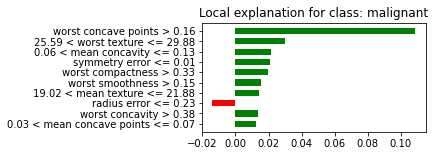

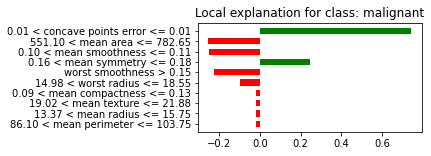

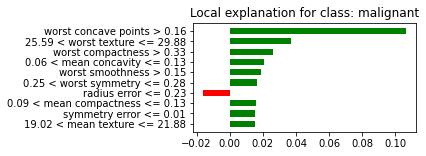

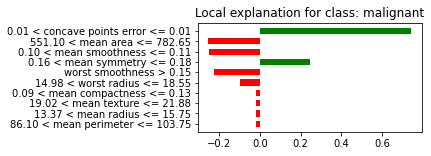

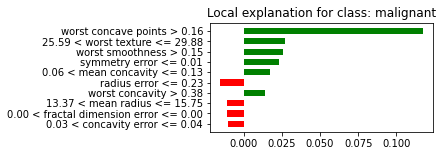

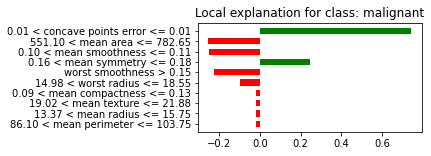

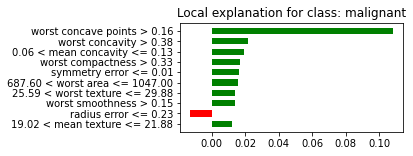

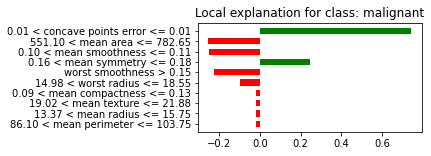

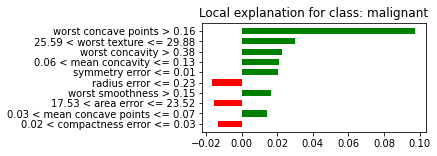

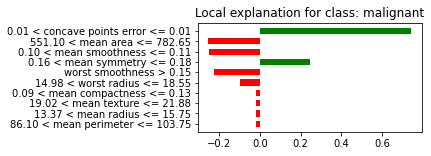

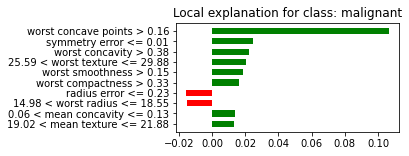

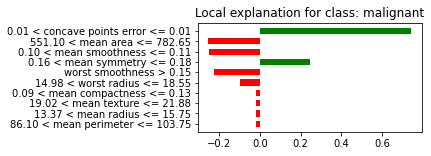

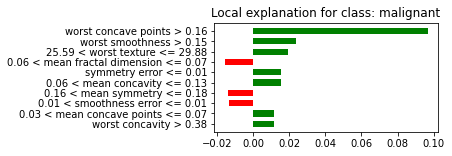

In [16]:
x = 2

dlime_exp = []
lime_exp = []

for i in range(0, 10):
        p_label = clabel[indices[x]]
        N = clustered_data[clustered_data[:, 30] == p_label]
        subset = np.delete(N, 30, axis=1)

        exp_dlime = explainer.explain_instance_hclust(test[x],
                                             rf.predict_proba,
                                             num_features=10,
                                             model_regressor=LinearRegression(),
                                             clustered_data = subset,
                                             regressor = 'linear', explainer='dlime', labels=(0,1))

        fig_dlime, r_features = exp_dlime.as_pyplot_to_figure(type='h', name = i+.2, label='0')
        # fig_dlime.show()
        dlime_exp.append(r_features)


        exp_lime = explainer.explain_instance_hclust(test[x],
                                             rf.predict_proba,
                                             num_features=10,
                                             model_regressor= LinearRegression(),
                                             regressor = 'linear', explainer = 'lime', labels=(0,1))

        fig_lime, r_features = exp_lime.as_pyplot_to_figure(type='h', name = i+.3, label='0')
        # fig_lime.show()
        lime_exp.append(r_features)

## Compute Jaccard distance among DLIME explanations

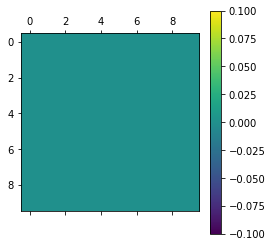

In [17]:
sim = jaccard_distance(dlime_exp)
#np.savetxt("results/nn_dlime_jdist_bc.csv", sim, delimiter=",")
#print(np.asarray(sim).mean())

plt.matshow(sim);
plt.colorbar()
#plt.savefig("results/sim_use_case_2.pdf", bbox_inches='tight')
#plt.show()

## Compute Jaccard distance among LIME explanations

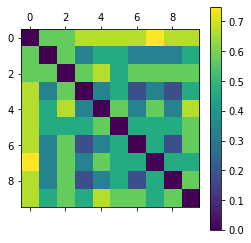

In [18]:
sim = jaccard_distance(lime_exp)
#np.savetxt("results/nn_lime_jdist_bc.csv", sim, delimiter=",")
#print(np.asarray(sim).mean())

plt.matshow(sim);
plt.colorbar()
#plt.savefig("results/sim_use_case_3.pdf", bbox_inches='tight')
#plt.show()

## Citation

: 